In [330]:
import numpy as np
import scipy.linalg as la
from scipy.linalg import eig, qr, block_diag
from numpy.linalg import svd
import control
from scipy.linalg import null_space
import math
import matplotlib.pyplot as plt


def subspace_dist(Phi1,Phi2):
    S_comp = null_space(Phi2.T)
    return la.norm(Phi1.T@S_comp,2)


def zo2p(A, B, Q, R, K, r, ns, gamma):
    dx = A.shape[0]
    du = B.shape[1]
    K1 = []
    K2 = []
    cost_1 = []
    cost_2 = []
    grad = np.zeros((du, dx))
    Ul=[]
    for l in range(ns):
        U = np.random.randn(B.shape[1], A.shape[0])
        U = (U / np.linalg.norm(U))

        K1.append(K + r*U)
        K2.append(K - r*U)

        # Compute cost
        x_0 = np.random.normal(0, 1, size=(1,dx))[0]
        cost_1.append(cost_gamma_x0(A, B, Q, R, K1[-1],gamma,x_0))
        cost_2.append(cost_gamma_x0(A, B, Q, R, K2[-1],gamma,x_0))
        Ul.append(U)

        grad += ((dx * du) / (2 * ns * (r))) * (cost_1[l] - cost_2[l]) * Ul[l]

    return grad


def cost_gamma(A, B, Q, R, K, gamma):
        dx = A.shape[0]
        tau = 50
        ns = 100
        cost = 0
        for i in range(ns):
            cost_i = 0
            x = np.random.normal(0, 1, size=(1,dx))[0]
            for t in range(tau):
                u = -K@x
                cost_i += (gamma**t)*(x.T@Q@x + u.T@R@u)
                x = (A-B@K)@x
            cost+=(1/ns)*cost_i  
        
        return cost
    
    
def cost_gamma_x0(A, B, Q, R, K, gamma, x):
        dx = A.shape[0]
        tau = 50
        cost = 0
        for t in range(tau):
            u = -K@x
            cost += (gamma**t)*(x.T@Q@x + u.T@R@u)
            x = (A-B@K)@x
        return cost
    
    
def find_stabilizing_hd(A,B,Q,R,gamma,N,r,ns,eta,xi):
    dx = A.shape[0]
    du = B.shape[1]
    K = np.zeros((du,dx))
    sr = []
    gammas = []
    k = 0
    flag = 0
    k0 = 0
    while gamma<1:
        
        sr.append(max(abs(la.eigvals(A-B@K))))
        gammas.append(gamma)
        print(f"Iteration: {k}, Spectral radius: {sr[-1]}, gamma: {gammas[-1]}")
        K_l = K
        for n in range(N):
            K_l=K_l - eta*zo2p(A, B, Q, R, K_l, r, ns, gamma)
        K = K_l
        eta = 0.98*eta
        #Update the discount factor
        sigma_min = min(abs(la.eigvals(Q + K.T@R@K)))
        alpha = sigma_min/(2*cost_gamma(A, B, Q, R, K, gamma) - sigma_min)
        gamma = (1+alpha*xi)*gamma
        if gamma>=1:
            gammas.append(gamma)
            break
        k+=1
    return K, sr, gammas

def find_stabilizing_ld(A,B,Q,R,gamma,N,r,ns,eta,Phi,A_hd,B_hd,xi):
    eta0 = eta
    dx = A.shape[0]
    du = B.shape[1]
    K = np.zeros((du,dx))
    sr_ld = []
    sr_hd = []
    gammas = []
    k = 0
    k0 = 0
    flag = 0
    while gamma<1:
        sr_ld.append(max(abs(la.eigvals(A-B@K))))
        sr_hd.append(max(abs(la.eigvals(A_hd-B_hd@K@Phi.T))))

        gammas.append(gamma)
        print(f"Iteration: {k}, Spectral radius: {sr_ld[-1]}, gamma: {gammas[-1]}")
        K_l = K
        #Local updates:
        for n in range(N):
            K_l=K_l - eta*zo2p(A, B, Q, R, K_l, r, ns, gamma)
        K = K_l
        eta = 0.98*eta
        #Update the discount factor
        sigma_min = min(abs(la.eigvals(Q + K.T@R@K)))
        alpha = sigma_min/(2*cost_gamma(A, B, Q, R, K, gamma) - sigma_min)
        gamma = (1+alpha*xi)*gamma
        if gamma>=1:
            gammas.append(gamma)
            break
        k+=1
    return K, sr_ld, sr_hd, gammas

def simulate_system(A,x):
    return A @ x

def get_basis(A):
    e_i_p = []
    for i in range(dx):
        e_i = np.zeros(dx)
        e_i[i] = 1
        e_i_p.append(simulate_system(A,e_i))
    return e_i_p

def adjoint_data(x0,T,e_i_p):
    dx = x0.shape[0]
    X = np.zeros((dx,T))
    x = x0
    for t in range(T):
        x_adj = np.zeros(dx)
        for i in range(dx):
            x_adj[i] = np.dot(e_i_p[i], x)
        x = x_adj
        X[:,t] = x.reshape(dx,)    
    return X

$\textbf{LTI system:}$

$\textbf{Random System:}$



In [463]:
d0 = 5
du = 3
#A_random_matrix = np.random.randn(d0,d0)
#A0 = 2*(A_random_matrix + A_random_matrix.T)/(la.norm(A_random_matrix + A_random_matrix.T,2))
#B_random_matrix = np.random.randn(d0,du)
#B0 = B_random_matrix/la.norm(B_random_matrix)


A0 = np.array([[ 0.67586377,  0.67635067, -0.16276205,  0.48673863,  0.44738657],
               [ 0.67635067,  0.45245428, -0.03864822, -0.01150764,  0.38821971],
               [-0.16276205, -0.03864822,  0.62493438,  0.77344597,  0.47457055],
               [ 0.48673863, -0.01150764,  0.77344597,  1.41277696, -0.34486429],
               [ 0.44738657,  0.38821971,  0.47457055, -0.34486429, -0.67022097]])

B0 = np.array([[-0.19574186,  0.21074345,  0.19124688],
       [ 0.00212721, -0.1684398 ,  0.31477715],
       [ 0.03942897, -0.22636223, -0.24697925],
       [-0.00861462,  0.10589009,  0.28954153],
       [ 0.48603157, -0.54459493,  0.10728937]])

In [434]:
nr = 5 #number of realizations

$\textbf{Case 1: (Algorithm 1)}\;\ dx = 20, \ell = 3$

In [435]:
dx = 20
#Algorithm parameters 
gamma = 0.1
ns = 20
r = 1e-3
N = 20
eta = 1e-3
xi = 0.9
srs1 = []
gammas1 = []
x = np.ones((dx,1))
for i in range(nr):
    
    #Augmenting the nominal system
    As = np.random.randn(dx-d0,dx-d0)
    A = block_diag(A0, 0.8*As/la.norm(As))

    Bs = np.zeros((dx-d0,du))
    B = np.concatenate((B0, Bs), axis=0)
    
    #Learning the left unstable subspce
    T = 40 #horizon length
    e_i_p = get_basis(A)
    D = adjoint_data(x,T,e_i_p)
    U,S,V = svd(D)
    Phi_hat = U[:,:l]
    x = np.random.rand(dx,1)
    Au = Phi_hat.T@A@Phi_hat
    Bu = Phi_hat.T@B
    Qu = Phi_hat.T@(100*np.eye(dx))@Phi_hat
    R = np.eye(du)
    print(f"Realization: {i}")
    K,_,sr1,gamms = find_stabilizing_ld(Au,Bu,Qu,R,gamma,N,r,ns,eta,Phi_hat,A,B,xi)
    print("-----------------")
    srs1.append(sr1)
    gammas1.append(gamms)

Realization: 0
Iteration: 0, Spectral radius: 1.9999999999999984, gamma: 0.1
Iteration: 1, Spectral radius: 1.9133287799537646, gamma: 0.11506756409930928
Iteration: 2, Spectral radius: 1.8507045837294687, gamma: 0.13343750224988513
Iteration: 3, Spectral radius: 1.7940228665595186, gamma: 0.15039697905210175
Iteration: 4, Spectral radius: 1.7584481129445124, gamma: 0.1658550565941899
Iteration: 5, Spectral radius: 1.7320084908345859, gamma: 0.18264982506239347
Iteration: 6, Spectral radius: 1.7085749147919023, gamma: 0.20426895523969218
Iteration: 7, Spectral radius: 1.6794481677993849, gamma: 0.223332537124298
Iteration: 8, Spectral radius: 1.6458048738581943, gamma: 0.24378782584289835
Iteration: 9, Spectral radius: 1.6149749470697365, gamma: 0.26638874751884917
Iteration: 10, Spectral radius: 1.567678646072559, gamma: 0.2846695109834368
Iteration: 11, Spectral radius: 1.5185799557280313, gamma: 0.30625696299017496
Iteration: 12, Spectral radius: 1.4630366445209453, gamma: 0.3255714

Iteration: 48, Spectral radius: 0.61514239810652, gamma: 0.8544231671759689
Iteration: 49, Spectral radius: 0.6101290320761924, gamma: 0.8696312364970774
Iteration: 50, Spectral radius: 0.6022552818672091, gamma: 0.8805319006242038
Iteration: 51, Spectral radius: 0.5971805335712069, gamma: 0.893289280448933
Iteration: 52, Spectral radius: 0.5790101811900469, gamma: 0.9054327821698548
Iteration: 53, Spectral radius: 0.5769729305201695, gamma: 0.9216244392297531
Iteration: 54, Spectral radius: 0.5716608151802445, gamma: 0.933542307871048
Iteration: 55, Spectral radius: 0.5733439887359084, gamma: 0.9469774680062967
Iteration: 56, Spectral radius: 0.5569556984286542, gamma: 0.9584074282796636
Iteration: 57, Spectral radius: 0.5518183441229756, gamma: 0.970543591834875
Iteration: 58, Spectral radius: 0.5500591870455122, gamma: 0.9867728018299606
Iteration: 59, Spectral radius: 0.5290959777162167, gamma: 0.9971228366581005
-----------------
Realization: 2
Iteration: 0, Spectral radius: 2.0, 

Iteration: 38, Spectral radius: 0.722792242977482, gamma: 0.7287569959726875
Iteration: 39, Spectral radius: 0.7173504012783349, gamma: 0.74422607424235
Iteration: 40, Spectral radius: 0.6995197234552681, gamma: 0.7562655527420323
Iteration: 41, Spectral radius: 0.6912543690259602, gamma: 0.7691845841947207
Iteration: 42, Spectral radius: 0.6836912366665799, gamma: 0.7793774914792053
Iteration: 43, Spectral radius: 0.6699764224548175, gamma: 0.7936740145694252
Iteration: 44, Spectral radius: 0.6600953021955305, gamma: 0.8070204807693784
Iteration: 45, Spectral radius: 0.6435734776929993, gamma: 0.8201077423157737
Iteration: 46, Spectral radius: 0.6337303910337929, gamma: 0.8339607111562376
Iteration: 47, Spectral radius: 0.6257423399901944, gamma: 0.8478739898096178
Iteration: 48, Spectral radius: 0.6283623954628018, gamma: 0.8636894901584232
Iteration: 49, Spectral radius: 0.6046564509671827, gamma: 0.8814411130272056
Iteration: 50, Spectral radius: 0.5986184304450324, gamma: 0.896696

In [436]:
dimg = 1e10
for i in range(nr):
    dimg = min(len(gammas1[i]),dimg) 
    
dimsr = 1e10
for i in range(nr):
    dimsr = min(len(srs1[i]),dimsr) 


gammas1r = np.zeros((nr,dimg))
sr1s = np.zeros((nr,dimsr))
for i in range(nr):
    gammas1r[i,:] = gammas1[i][:dimg]
    sr1s[i,:] = srs1[i][:dimsr]

$\textbf{Closed-loop spectral radius:}$

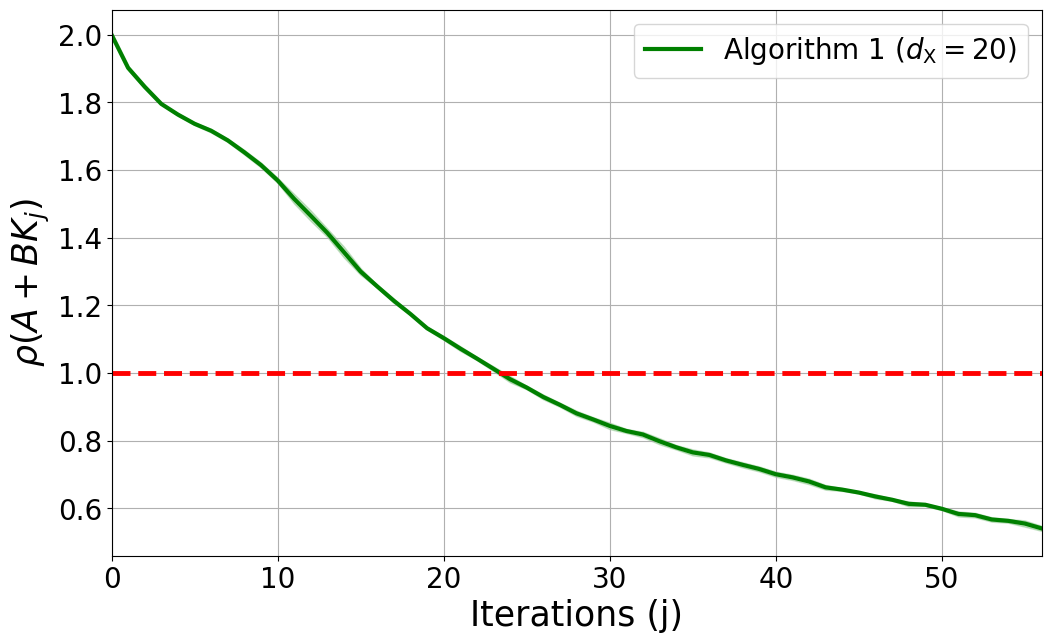

In [446]:
plt.figure(figsize=(12,7))

# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(sr1s, axis=0)
sem_1 = np.std(sr1s, axis=0) / np.sqrt(sr1s.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 20)$', color='green', linewidth=3)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)
plt.plot(np.arange(dimsr), np.ones(dimsr), linestyle='--', color='red', linewidth=3.5)


plt.ylabel(r'$\rho(A+BK_{j})$',fontsize=25)
plt.xlabel('Iterations (j)',fontsize=25)
plt.tick_params(axis='both', labelsize=20)
plt.xlim(0, dimsr-1)

plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels,fontsize=20)
plt.subplots_adjust(bottom=0.10)
plt.grid()

$\textbf{Discount factor:}$

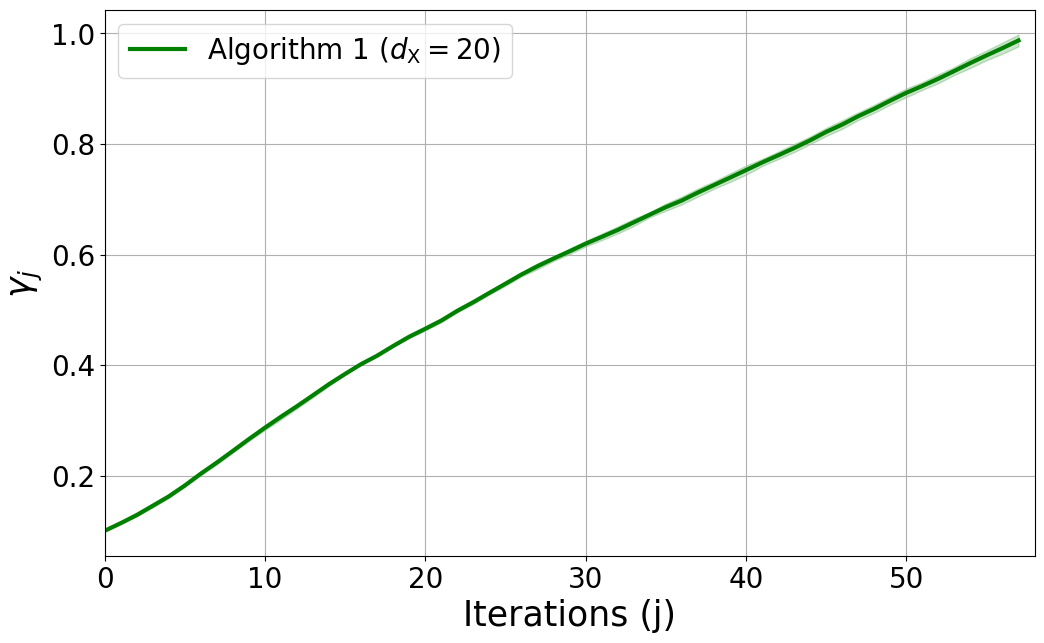

In [448]:
plt.figure(figsize=(12,7))

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(gammas1r, axis=0)
sem_1 = np.std(gammas1r, axis=0) / np.sqrt(gammas1r.shape[0])

plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 20)$', color='green', linewidth=3)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)

plt.ylabel(r'$\gamma_j$',fontsize=25)
plt.xlabel('Iterations (j)',fontsize=25)
plt.tick_params(axis='both', labelsize=20)
plt.xlim(0, dimg)

plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels,fontsize=20)
plt.subplots_adjust(bottom=0.10)
plt.grid()

$\textbf{Case 2: (LTS all modes)}\;\ dx = 20, \ell = 3$

In [440]:
dx = 20
#Algorithm parameters 
gamma = 0.1
ns = 20
r = 1e-3
N = 20
eta = 1e-3
xi = 0.9
srs2 = []
gammas2 = []
for i in range(nr):
    
    #Augmenting the nominal system
    As = np.random.randn(dx-d0,dx-d0)
    A = block_diag(A0, 0.8*As/la.norm(As))

    Bs = np.zeros((dx-d0,du))
    B = np.concatenate((B0, Bs), axis=0)
    
    Q = 100*np.eye(dx)
    R = np.eye(du)
    
    print(f"Realization: {i}")
    K,sr2,gamms2 = find_stabilizing_hd(A,B,Q,R,gamma,N,r,ns,eta,xi)
    print("-----------------")
    srs2.append(sr2)
    gammas2.append(gamms2)

Realization: 0
Iteration: 0, Spectral radius: 1.9999999999999996, gamma: 0.1
Iteration: 1, Spectral radius: 1.9373485647357032, gamma: 0.10225501439290317
Iteration: 2, Spectral radius: 1.9060937444316979, gamma: 0.1045287963979507
Iteration: 3, Spectral radius: 1.8539500302315992, gamma: 0.1068685805283983
Iteration: 4, Spectral radius: 1.8333666257982029, gamma: 0.10921688997763832
Iteration: 5, Spectral radius: 1.8192420114989658, gamma: 0.11161137835035233
Iteration: 6, Spectral radius: 1.8129015567552758, gamma: 0.1140394059599984
Iteration: 7, Spectral radius: 1.8117211478282496, gamma: 0.11665094777781002
Iteration: 8, Spectral radius: 1.808865774612419, gamma: 0.11921463637298246
Iteration: 9, Spectral radius: 1.806183990317817, gamma: 0.1217654028673597
Iteration: 10, Spectral radius: 1.7943336575516815, gamma: 0.12444861830413344
Iteration: 11, Spectral radius: 1.789566796845977, gamma: 0.12711673402405188
Iteration: 12, Spectral radius: 1.7927982115657497, gamma: 0.129982768

Iteration: 105, Spectral radius: 0.9658067271330443, gamma: 0.5488203800186172
Iteration: 106, Spectral radius: 0.9577644483662223, gamma: 0.5536693826985465
Iteration: 107, Spectral radius: 0.9547018252234364, gamma: 0.5594742045590859
Iteration: 108, Spectral radius: 0.9380947125920227, gamma: 0.5641374384412284
Iteration: 109, Spectral radius: 0.9266833902456102, gamma: 0.5679651344448763
Iteration: 110, Spectral radius: 0.9241978807837274, gamma: 0.5724723201729273
Iteration: 111, Spectral radius: 0.9115442016581343, gamma: 0.5763170205593215
Iteration: 112, Spectral radius: 0.9026171963590304, gamma: 0.5801743520832143
Iteration: 113, Spectral radius: 0.8919039703038029, gamma: 0.5847575103151891
Iteration: 114, Spectral radius: 0.8960737517623556, gamma: 0.5890489104633171
Iteration: 115, Spectral radius: 0.8978732357988607, gamma: 0.5926952435562516
Iteration: 116, Spectral radius: 0.8924118692058718, gamma: 0.5975879017789947
Iteration: 117, Spectral radius: 0.8824473825231806,

Iteration: 210, Spectral radius: 0.5628051922281765, gamma: 0.9644858608589326
Iteration: 211, Spectral radius: 0.5610523225355707, gamma: 0.9683560723796873
Iteration: 212, Spectral radius: 0.5507077198932279, gamma: 0.9717673854424124
Iteration: 213, Spectral radius: 0.5560636351239446, gamma: 0.9753701249561293
Iteration: 214, Spectral radius: 0.5467695861355552, gamma: 0.9784099420770432
Iteration: 215, Spectral radius: 0.5449196035324244, gamma: 0.9818187945476519
Iteration: 216, Spectral radius: 0.5415065605148279, gamma: 0.9855424648731408
Iteration: 217, Spectral radius: 0.5447673199064069, gamma: 0.989045879454075
Iteration: 218, Spectral radius: 0.5419500810117742, gamma: 0.9918728430358105
Iteration: 219, Spectral radius: 0.5433635634052232, gamma: 0.9951688932993582
Iteration: 220, Spectral radius: 0.5389703823428849, gamma: 0.9985807721734825
-----------------
Realization: 1
Iteration: 0, Spectral radius: 1.9999999999999996, gamma: 0.1
Iteration: 1, Spectral radius: 1.9017

Iteration: 94, Spectral radius: 1.050365147864517, gamma: 0.49655631309594955
Iteration: 95, Spectral radius: 1.0441779646322813, gamma: 0.5010171490608643
Iteration: 96, Spectral radius: 1.0181098214388904, gamma: 0.5054596592261995
Iteration: 97, Spectral radius: 1.026832439841846, gamma: 0.5096901828851618
Iteration: 98, Spectral radius: 1.0225924988499384, gamma: 0.5146446332510258
Iteration: 99, Spectral radius: 1.0081234026865622, gamma: 0.5194390537125192
Iteration: 100, Spectral radius: 1.008676027960195, gamma: 0.523423897814448
Iteration: 101, Spectral radius: 0.9972454103905628, gamma: 0.5276637237104335
Iteration: 102, Spectral radius: 0.9872846210691306, gamma: 0.5316085117918357
Iteration: 103, Spectral radius: 0.976910084689989, gamma: 0.5363860385791464
Iteration: 104, Spectral radius: 0.9856460269202358, gamma: 0.5406771335706864
Iteration: 105, Spectral radius: 0.9644669508006405, gamma: 0.5446012728695815
Iteration: 106, Spectral radius: 0.9591828310670116, gamma: 0.

Iteration: 199, Spectral radius: 0.5939982846003774, gamma: 0.9166129595599211
Iteration: 200, Spectral radius: 0.5801739994259651, gamma: 0.9202340934355354
Iteration: 201, Spectral radius: 0.5808826099081167, gamma: 0.9237510661692114
Iteration: 202, Spectral radius: 0.5832225329524592, gamma: 0.9272674996215153
Iteration: 203, Spectral radius: 0.584701240040564, gamma: 0.9311941476842603
Iteration: 204, Spectral radius: 0.5775804185202225, gamma: 0.9349090966057444
Iteration: 205, Spectral radius: 0.5681258724158684, gamma: 0.9384491751061161
Iteration: 206, Spectral radius: 0.566009374351437, gamma: 0.9414542979015484
Iteration: 207, Spectral radius: 0.5759049649947792, gamma: 0.9447224517527053
Iteration: 208, Spectral radius: 0.5722359980535274, gamma: 0.9476759479048273
Iteration: 209, Spectral radius: 0.5618453037985979, gamma: 0.9515563832575846
Iteration: 210, Spectral radius: 0.560637545971262, gamma: 0.9554192215615867
Iteration: 211, Spectral radius: 0.5675176947981653, ga

Iteration: 81, Spectral radius: 1.1760874430462884, gamma: 0.4395318759481459
Iteration: 82, Spectral radius: 1.1663063431290424, gamma: 0.4450200037472437
Iteration: 83, Spectral radius: 1.1497637230094906, gamma: 0.4495382992099116
Iteration: 84, Spectral radius: 1.141174120318667, gamma: 0.4539197589244204
Iteration: 85, Spectral radius: 1.1340406018611497, gamma: 0.45899503819191884
Iteration: 86, Spectral radius: 1.108966471664166, gamma: 0.46335038421817626
Iteration: 87, Spectral radius: 1.1147754878241773, gamma: 0.4678579799963064
Iteration: 88, Spectral radius: 1.106660061499002, gamma: 0.4727588840337901
Iteration: 89, Spectral radius: 1.0976755515507153, gamma: 0.4767916018382126
Iteration: 90, Spectral radius: 1.0859320838278812, gamma: 0.48137940776961197
Iteration: 91, Spectral radius: 1.0722334643267364, gamma: 0.48556066675331755
Iteration: 92, Spectral radius: 1.0616378140367513, gamma: 0.4896575114643541
Iteration: 93, Spectral radius: 1.0550749807650486, gamma: 0.49

Iteration: 187, Spectral radius: 0.6141923016089597, gamma: 0.8783753967089838
Iteration: 188, Spectral radius: 0.6104560558538188, gamma: 0.8817709950546455
Iteration: 189, Spectral radius: 0.5973666759844048, gamma: 0.8848872061877708
Iteration: 190, Spectral radius: 0.5942496220717532, gamma: 0.8880509972021539
Iteration: 191, Spectral radius: 0.6091596444689001, gamma: 0.8929256315098877
Iteration: 192, Spectral radius: 0.6070294243533565, gamma: 0.8972164634495469
Iteration: 193, Spectral radius: 0.6002291554173429, gamma: 0.9007677830232566
Iteration: 194, Spectral radius: 0.6047073905647038, gamma: 0.9053075068153662
Iteration: 195, Spectral radius: 0.5907884237785119, gamma: 0.9085291001812652
Iteration: 196, Spectral radius: 0.5935847468008665, gamma: 0.9126939022126778
Iteration: 197, Spectral radius: 0.5922375163441025, gamma: 0.9162698862965039
Iteration: 198, Spectral radius: 0.5750930268493546, gamma: 0.9200816727074674
Iteration: 199, Spectral radius: 0.5876716514911406,

Iteration: 72, Spectral radius: 1.297495037530123, gamma: 0.39166889957114664
Iteration: 73, Spectral radius: 1.2762180629578757, gamma: 0.39670315188390026
Iteration: 74, Spectral radius: 1.261259988925262, gamma: 0.4016738830907853
Iteration: 75, Spectral radius: 1.2519420231137994, gamma: 0.4066119213192046
Iteration: 76, Spectral radius: 1.2434993144312771, gamma: 0.4122414941239712
Iteration: 77, Spectral radius: 1.2287038593223403, gamma: 0.4166659474002114
Iteration: 78, Spectral radius: 1.2166362070338645, gamma: 0.42224586803932496
Iteration: 79, Spectral radius: 1.2125775242828853, gamma: 0.4272745898612753
Iteration: 80, Spectral radius: 1.1940082115376733, gamma: 0.43219418983236596
Iteration: 81, Spectral radius: 1.1867108322431144, gamma: 0.4370685629543194
Iteration: 82, Spectral radius: 1.1664704874808112, gamma: 0.44294038756116877
Iteration: 83, Spectral radius: 1.1575712113463692, gamma: 0.44715510112096835
Iteration: 84, Spectral radius: 1.1524541558385293, gamma: 0

Iteration: 178, Spectral radius: 0.6392893871528902, gamma: 0.8471424429665974
Iteration: 179, Spectral radius: 0.6218544209926311, gamma: 0.850942679463292
Iteration: 180, Spectral radius: 0.6310469377681086, gamma: 0.854967097862902
Iteration: 181, Spectral radius: 0.6344386705202217, gamma: 0.8592644490619706
Iteration: 182, Spectral radius: 0.6264862194153814, gamma: 0.8626881855394011
Iteration: 183, Spectral radius: 0.6249399074796251, gamma: 0.866155391806703
Iteration: 184, Spectral radius: 0.6244480115085415, gamma: 0.8694814503378709
Iteration: 185, Spectral radius: 0.6222316368920944, gamma: 0.8734265938703659
Iteration: 186, Spectral radius: 0.6161966762785148, gamma: 0.8771237998899527
Iteration: 187, Spectral radius: 0.6056402070046796, gamma: 0.8819655627982715
Iteration: 188, Spectral radius: 0.606227856699699, gamma: 0.8856346504188808
Iteration: 189, Spectral radius: 0.6042574752447392, gamma: 0.889855810855703
Iteration: 190, Spectral radius: 0.5959976703934288, gamm

Iteration: 64, Spectral radius: 1.402085645899005, gamma: 0.3513595287530244
Iteration: 65, Spectral radius: 1.3891160953162647, gamma: 0.3561234838732992
Iteration: 66, Spectral radius: 1.383907283506196, gamma: 0.36099162551262665
Iteration: 67, Spectral radius: 1.3661424339895734, gamma: 0.36651536026090487
Iteration: 68, Spectral radius: 1.3532659855992883, gamma: 0.371876920491783
Iteration: 69, Spectral radius: 1.3321184838532552, gamma: 0.3769392421223504
Iteration: 70, Spectral radius: 1.326917554750852, gamma: 0.38143438520908124
Iteration: 71, Spectral radius: 1.3162644996158168, gamma: 0.3863927347128538
Iteration: 72, Spectral radius: 1.305320336174362, gamma: 0.39088751360427076
Iteration: 73, Spectral radius: 1.2833944743475243, gamma: 0.3959526983750104
Iteration: 74, Spectral radius: 1.2804867191995046, gamma: 0.4007602806532741
Iteration: 75, Spectral radius: 1.2540776343605926, gamma: 0.4056201754116026
Iteration: 76, Spectral radius: 1.2514563374413759, gamma: 0.4103

Iteration: 169, Spectral radius: 0.6649906029020283, gamma: 0.8032323139520317
Iteration: 170, Spectral radius: 0.6670310641244028, gamma: 0.8078924774433606
Iteration: 171, Spectral radius: 0.660449255226598, gamma: 0.8116439621802064
Iteration: 172, Spectral radius: 0.6541334840705944, gamma: 0.8157832755861325
Iteration: 173, Spectral radius: 0.6518534251393424, gamma: 0.8192695064305228
Iteration: 174, Spectral radius: 0.6581815617936331, gamma: 0.8228034397336734
Iteration: 175, Spectral radius: 0.6462944437719116, gamma: 0.827078117192968
Iteration: 176, Spectral radius: 0.6382913072680034, gamma: 0.8305470060815707
Iteration: 177, Spectral radius: 0.6431652706788087, gamma: 0.8342215862339067
Iteration: 178, Spectral radius: 0.6515210478258657, gamma: 0.8380246688418234
Iteration: 179, Spectral radius: 0.6434044702105512, gamma: 0.8413426551693046
Iteration: 180, Spectral radius: 0.649112967425321, gamma: 0.8447755016666106
Iteration: 181, Spectral radius: 0.6359050039072163, ga

In [441]:
dim2g = 1e10
for i in range(nr):
    dim2g = min(len(gammas2[i]),dim2g)
    
dim2sr = 1e10
for i in range(nr):
    dim2sr = min(len(srs2[i]),dim2sr)


gammas2r = np.zeros((nr,dim2g))
sr2s = np.zeros((nr,dim2sr))
for i in range(nr):
    gammas2r[i,:] = gammas2[i][:dim2g]
    sr2s[i,:] = srs2[i][:dim2sr]

$\textbf{Case 3: (LTS all modes)}\;\ dx = 10, \ell = 3$

In [442]:
dx = 10
#Algorithm parameters 
gamma = 0.1
ns = 20
r = 1e-3
N = 20
eta = 1e-3
xi = 0.9
srs3 = []
gammas3 = []
for i in range(nr):

    As = np.random.randn(dx-d0,dx-d0)
    A = block_diag(A0, 0.8*As/la.norm(As))

    Bs = np.zeros((dx-d0,du))
    B = np.concatenate((B0, Bs), axis=0)
    
    Q = 100*np.eye(dx)
    R = np.eye(du)
    print(f"Realization: {i}")
    K,sr3,gamms3 = find_stabilizing_hd(A,B,Q,R,gamma,N,r,ns,eta,xi)
    print("-----------------")
    srs3.append(sr3)
    gammas3.append(gamms3)

Realization: 0
Iteration: 0, Spectral radius: 1.9999999999999996, gamma: 0.1
Iteration: 1, Spectral radius: 1.9149452116817958, gamma: 0.1046395841085077
Iteration: 2, Spectral radius: 1.865367568831965, gamma: 0.10918651137295114
Iteration: 3, Spectral radius: 1.8314212808697556, gamma: 0.11399945285015463
Iteration: 4, Spectral radius: 1.8163273526218293, gamma: 0.11896380048745397
Iteration: 5, Spectral radius: 1.795806238832036, gamma: 0.12408560372250282
Iteration: 6, Spectral radius: 1.7935704021006584, gamma: 0.1289244385609404
Iteration: 7, Spectral radius: 1.7843492200167395, gamma: 0.13421386809571814
Iteration: 8, Spectral radius: 1.7789572917644088, gamma: 0.1403351991670753
Iteration: 9, Spectral radius: 1.776696875280391, gamma: 0.14612351774869173
Iteration: 10, Spectral radius: 1.7729485554777158, gamma: 0.1524855401340103
Iteration: 11, Spectral radius: 1.7697248521935567, gamma: 0.15882890908548183
Iteration: 12, Spectral radius: 1.7690979566534835, gamma: 0.165170268

Iteration: 106, Spectral radius: 0.7194961309202231, gamma: 0.7456740430219051
Iteration: 107, Spectral radius: 0.7136229645114658, gamma: 0.7500293472847233
Iteration: 108, Spectral radius: 0.7136046729779293, gamma: 0.7534630576630741
Iteration: 109, Spectral radius: 0.7084763524737828, gamma: 0.7579448657055062
Iteration: 110, Spectral radius: 0.7082074143263657, gamma: 0.7630866273776883
Iteration: 111, Spectral radius: 0.6966710483679531, gamma: 0.7670861199312349
Iteration: 112, Spectral radius: 0.6924686253699144, gamma: 0.7713793239328266
Iteration: 113, Spectral radius: 0.6887240575350702, gamma: 0.7751086359148879
Iteration: 114, Spectral radius: 0.6848788824500055, gamma: 0.7788675182513165
Iteration: 115, Spectral radius: 0.6858775673691944, gamma: 0.784041835216974
Iteration: 116, Spectral radius: 0.6794470119365383, gamma: 0.7882291938669533
Iteration: 117, Spectral radius: 0.6795838452770847, gamma: 0.7916555572507263
Iteration: 118, Spectral radius: 0.6776767836320636, 

Iteration: 41, Spectral radius: 1.3041391135640608, gamma: 0.39086221389053677
Iteration: 42, Spectral radius: 1.283663380559397, gamma: 0.3974249518052149
Iteration: 43, Spectral radius: 1.2632596250720851, gamma: 0.40457313470500383
Iteration: 44, Spectral radius: 1.2451961977863646, gamma: 0.41193840134906223
Iteration: 45, Spectral radius: 1.2308472094846303, gamma: 0.4177326254918467
Iteration: 46, Spectral radius: 1.21914798231714, gamma: 0.4249006915375101
Iteration: 47, Spectral radius: 1.194509349117409, gamma: 0.4316986555179414
Iteration: 48, Spectral radius: 1.1816506903129593, gamma: 0.437663278706922
Iteration: 49, Spectral radius: 1.1712411322419913, gamma: 0.4444754570803272
Iteration: 50, Spectral radius: 1.1545222528235872, gamma: 0.4498763377401855
Iteration: 51, Spectral radius: 1.1447450749036385, gamma: 0.45561396007507726
Iteration: 52, Spectral radius: 1.1241527906585835, gamma: 0.46119983702938544
Iteration: 53, Spectral radius: 1.1201130222937932, gamma: 0.466

Iteration: 147, Spectral radius: 0.5937056742149089, gamma: 0.904143364593793
Iteration: 148, Spectral radius: 0.5898183531664052, gamma: 0.9083870934864968
Iteration: 149, Spectral radius: 0.5874650478674718, gamma: 0.9130241508855057
Iteration: 150, Spectral radius: 0.5879366201283387, gamma: 0.9177319224987257
Iteration: 151, Spectral radius: 0.5886571278473294, gamma: 0.9211760330267311
Iteration: 152, Spectral radius: 0.5840243710650055, gamma: 0.925443263078678
Iteration: 153, Spectral radius: 0.580410950286258, gamma: 0.9291356087540044
Iteration: 154, Spectral radius: 0.5785513036900798, gamma: 0.9329450075636077
Iteration: 155, Spectral radius: 0.5733678694489045, gamma: 0.9373219242785611
Iteration: 156, Spectral radius: 0.5740111453620379, gamma: 0.9415101780212581
Iteration: 157, Spectral radius: 0.5702356932441595, gamma: 0.9458631335995682
Iteration: 158, Spectral radius: 0.5599339739469253, gamma: 0.9501303627282487
Iteration: 159, Spectral radius: 0.5599785860863146, ga

Iteration: 82, Spectral radius: 0.8553474695304697, gamma: 0.6224435438203105
Iteration: 83, Spectral radius: 0.856547768691824, gamma: 0.6275092013866637
Iteration: 84, Spectral radius: 0.8418264366214975, gamma: 0.6339236520342344
Iteration: 85, Spectral radius: 0.831852986889636, gamma: 0.6386856627885771
Iteration: 86, Spectral radius: 0.8211160322540023, gamma: 0.6441613923836338
Iteration: 87, Spectral radius: 0.8268694342665728, gamma: 0.6486547043451698
Iteration: 88, Spectral radius: 0.8095360020287217, gamma: 0.6529729629003445
Iteration: 89, Spectral radius: 0.815131057577617, gamma: 0.6571232309981454
Iteration: 90, Spectral radius: 0.8029167378856685, gamma: 0.6610058110297977
Iteration: 91, Spectral radius: 0.7944914782186394, gamma: 0.6658321493868545
Iteration: 92, Spectral radius: 0.8012652158127072, gamma: 0.6701033459759465
Iteration: 93, Spectral radius: 0.7895027198874149, gamma: 0.6756640556115516
Iteration: 94, Spectral radius: 0.7890202204941184, gamma: 0.679848

Iteration: 17, Spectral radius: 1.739167113764274, gamma: 0.19880095400106004
Iteration: 18, Spectral radius: 1.7316785565179376, gamma: 0.20652618641193765
Iteration: 19, Spectral radius: 1.7248638142261976, gamma: 0.21497326618221507
Iteration: 20, Spectral radius: 1.7108490084913175, gamma: 0.22303733752780702
Iteration: 21, Spectral radius: 1.7005997883118442, gamma: 0.23075322319612576
Iteration: 22, Spectral radius: 1.6901683364171407, gamma: 0.23930979298239144
Iteration: 23, Spectral radius: 1.6730178725715428, gamma: 0.2479888235023056
Iteration: 24, Spectral radius: 1.6540033892140171, gamma: 0.2558536394560265
Iteration: 25, Spectral radius: 1.6389638194274525, gamma: 0.26448817777713673
Iteration: 26, Spectral radius: 1.6237310180311835, gamma: 0.2718643680617744
Iteration: 27, Spectral radius: 1.6052555222630347, gamma: 0.28028349399656965
Iteration: 28, Spectral radius: 1.5886016508683203, gamma: 0.28899500888503804
Iteration: 29, Spectral radius: 1.5660469779362818, gamm

Iteration: 123, Spectral radius: 0.6576268802318496, gamma: 0.8153635214326406
Iteration: 124, Spectral radius: 0.6530147083196497, gamma: 0.8187683172156773
Iteration: 125, Spectral radius: 0.6535965091135032, gamma: 0.8232371872654575
Iteration: 126, Spectral radius: 0.6516634166631446, gamma: 0.8274947622022412
Iteration: 127, Spectral radius: 0.6415034640828293, gamma: 0.8330166471318255
Iteration: 128, Spectral radius: 0.6386537034155843, gamma: 0.8365267859071556
Iteration: 129, Spectral radius: 0.643014939170144, gamma: 0.8414187559335794
Iteration: 130, Spectral radius: 0.6374117103123957, gamma: 0.8453553307147572
Iteration: 131, Spectral radius: 0.6325955874789853, gamma: 0.850445795106002
Iteration: 132, Spectral radius: 0.6324733060413549, gamma: 0.8549103514322205
Iteration: 133, Spectral radius: 0.6228328552326334, gamma: 0.8586062432908901
Iteration: 134, Spectral radius: 0.6252971657758438, gamma: 0.8621739458674303
Iteration: 135, Spectral radius: 0.6195973200898104, g

Iteration: 59, Spectral radius: 1.0155793102563462, gamma: 0.514931523187597
Iteration: 60, Spectral radius: 1.0070877219476668, gamma: 0.5215281965471559
Iteration: 61, Spectral radius: 1.0012831199650412, gamma: 0.5268138791257819
Iteration: 62, Spectral radius: 0.9905684956748553, gamma: 0.531460149133736
Iteration: 63, Spectral radius: 0.9838940658495602, gamma: 0.5362894362548658
Iteration: 64, Spectral radius: 0.9722624220603413, gamma: 0.5421652339878748
Iteration: 65, Spectral radius: 0.9653765704984583, gamma: 0.5476236225200075
Iteration: 66, Spectral radius: 0.9620408775952838, gamma: 0.5542310958586897
Iteration: 67, Spectral radius: 0.9424767794695834, gamma: 0.5594516586158039
Iteration: 68, Spectral radius: 0.9412577750185505, gamma: 0.5644345724738553
Iteration: 69, Spectral radius: 0.9225374235433563, gamma: 0.5704037605828471
Iteration: 70, Spectral radius: 0.919034318162838, gamma: 0.5753300485046224
Iteration: 71, Spectral radius: 0.9203990332034996, gamma: 0.579916

Iteration: 164, Spectral radius: 0.5534987266748174, gamma: 0.9807648977527367
Iteration: 165, Spectral radius: 0.5520089697054682, gamma: 0.9833330164445262
Iteration: 166, Spectral radius: 0.5508733487820519, gamma: 0.9864342659322406
Iteration: 167, Spectral radius: 0.5440624744228173, gamma: 0.9899962843065554
Iteration: 168, Spectral radius: 0.5418768717779733, gamma: 0.993318482789753
Iteration: 169, Spectral radius: 0.5412857930394925, gamma: 0.9978039537463025
-----------------


In [443]:
dim3g = 1e10
for i in range(nr):
    dim3g = min(len(gammas3[i]),dim3g)
    
dim3sr = 1e10
for i in range(nr):
    dim3sr = min(len(srs3[i]),dim3sr)


gammas3r = np.zeros((nr,dim3g))
sr3s = np.zeros((nr,dim3sr))
for i in range(nr):
    gammas3r[i,:] = gammas3[i][:dim3g]
    sr3s[i,:] = srs3[i][:dim3sr]

$\textbf{Closed-loop spectral radius:}$

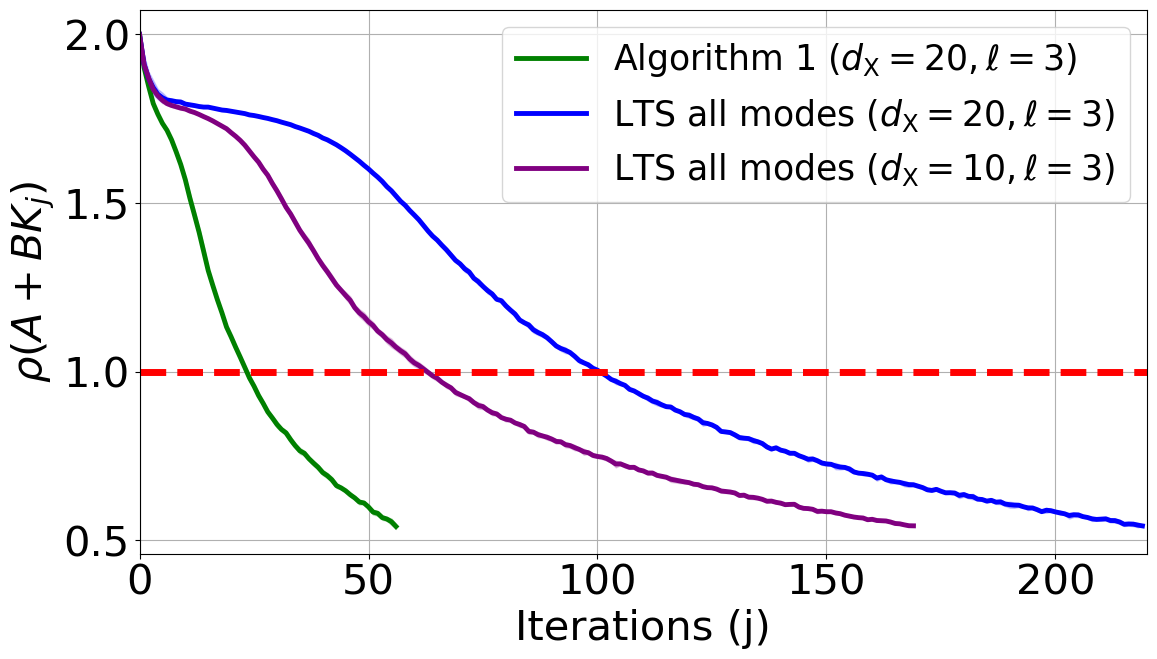

In [459]:
plt.figure(figsize=(13,8))


# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(sr1s, axis=0)
sem_1 = np.std(sr1s, axis=0) / np.sqrt(sr1s.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(sr2s, axis=0)
sem_2 = np.std(sr2s, axis=0) / np.sqrt(sr2s.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(sr2s, axis=0)
sem_2 = np.std(sr2s, axis=0) / np.sqrt(sr2s.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2

# Calculate mean and standard error of the mean (SEM)
mean_3 = np.mean(sr3s, axis=0)
sem_3 = np.std(sr3s, axis=0) / np.sqrt(sr3s.shape[0])

# Calculate 95% confidence intervals
ci_3 = 1.95*sem_3


plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 20,\ell = 3)$', color='green', linewidth=3.5)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)

plot_2=plt.plot(np.arange(len(mean_2)), mean_2, label=r'LTS all modes $(d_{\mathsf{X}} = 20, \ell = 3)$', color='blue', linewidth=3.5)
fill_2=plt.fill_between(np.arange(len(mean_2)), mean_2-ci_2, mean_2+ci_2, color='blue', alpha=0.2)

plot_3=plt.plot(np.arange(len(mean_3)), mean_3, label=r'LTS all modes $(d_{\mathsf{X}} = 10, \ell = 3)$', color='purple', linewidth=3.5)
fill_3=plt.fill_between(np.arange(len(mean_3)), mean_3-ci_3, mean_3+ci_3, color='purple', alpha=0.2)

plt.plot(np.arange(dim2), np.ones(dim2), linestyle='--', color='red', linewidth=5)


plt.ylabel(r'$\rho(A+BK_{j})$',fontsize=30)
plt.xlabel('Iterations (j)',fontsize=30)
plt.tick_params(axis='both', labelsize=30)
plt.xlim(0, dim2sr)

plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:3]  
labels = labels[:3]
plt.legend(handles=handles, labels=labels,fontsize=25)
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig("spectral_radius_random_matrices.pdf")

$\textbf{Discount factor:}$

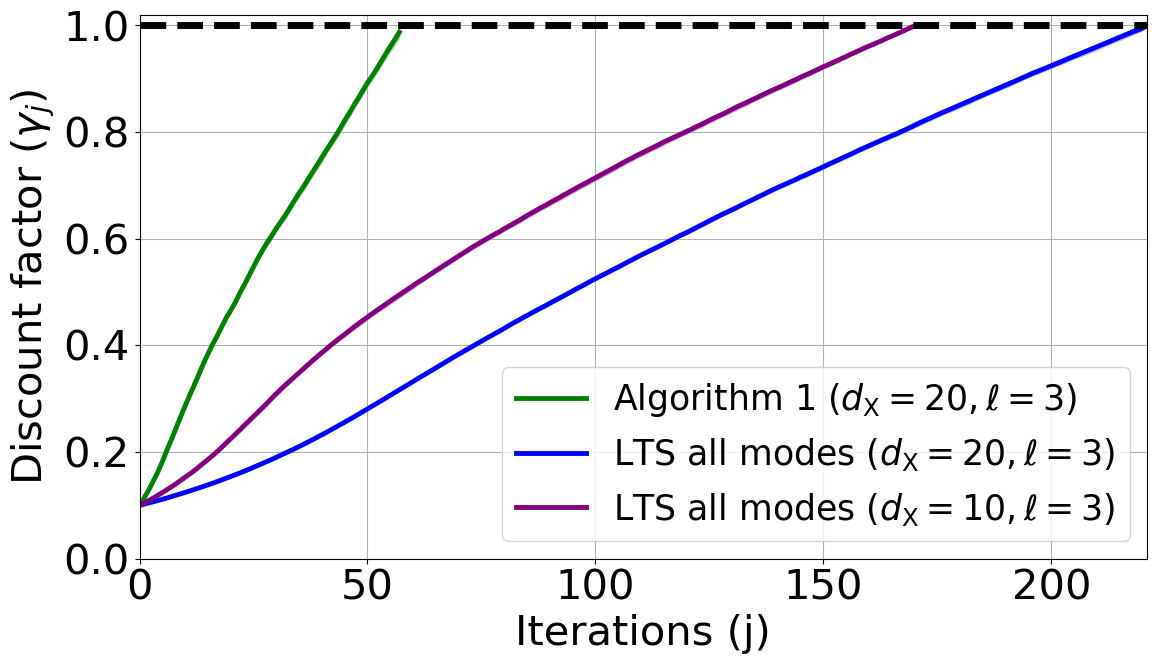

In [458]:
plt.figure(figsize=(13,8))

# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(gammas1r, axis=0)
sem_1 = np.std(gammas1r, axis=0) / np.sqrt(gammas1r.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(gammas2r, axis=0)
sem_2 = np.std(gammas2r, axis=0) / np.sqrt(gammas2r.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2

# Calculate mean and standard error of the mean (SEM)
mean_3 = np.mean(gammas3r, axis=0)
sem_3 = np.std(gammas3r, axis=0) / np.sqrt(gammas3r.shape[0])

# Calculate 95% confidence intervals
ci_3 = 1.95*sem_3

plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 20, \ell = 3)$', color='green', linewidth=3.5)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)

plot_2=plt.plot(np.arange(len(mean_2)), mean_2, label=r'LTS all modes $(d_{\mathsf{X}} = 20, \ell = 3)$', color='blue', linewidth=3.5)
fill_2=plt.fill_between(np.arange(len(mean_2)), mean_2-ci_2, mean_2+ci_2, color='blue', alpha=0.2)

plot_3=plt.plot(np.arange(len(mean_3)), mean_3, label=r'LTS all modes $(d_{\mathsf{X}} = 10, \ell = 3)$', color='purple', linewidth=3.5)
fill_3=plt.fill_between(np.arange(len(mean_3)), mean_3-ci_3, mean_3+ci_3, color='purple', alpha=0.2)

plt.plot(np.arange(dim2), np.ones(dim2), linestyle='--', color='black', linewidth=5)

plt.ylabel(r'Discount factor $(\gamma_j)$',fontsize=30)
plt.xlabel('Iterations (j)',fontsize=30)
plt.tick_params(axis='both', labelsize=30)
plt.xlim(0, dim2g)
plt.ylim(0, 1.02)

plt.legend(loc='lower right', fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:3] 
labels = labels[:3]
plt.legend(loc='lower right',handles=handles, labels=labels,fontsize=25)
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig("gamma_random_matrices.pdf")